In [1]:
from astropy import units as u
from astropy.coordinates import SkyCoord
from photutils.aperture import CircularAnnulus, SkyCircularAnnulus, CircularAperture, SkyCircularAperture
from astropy.coordinates import Angle

from astropy.io import fits
from astropy.io import ascii
from astropy.wcs import WCS

from astropy.visualization import simple_norm

import matplotlib.pyplot as plt

import numpy as np

from astropy.coordinates import FK5

from photutils.aperture import ApertureStats
from photutils.aperture import aperture_photometry

from astropy.stats import SigmaClip, mad_std

from photutils.utils import calc_total_error

import aswcs

from pathlib import Path
from tqdm import tqdm

from astropy.time import Time
from astropy.table import Table

import ccdproc as ccdp
from astropy.nddata import CCDData, StdDevUncertainty

from astropy.timeseries import LombScargle

In [2]:
import os
os.getcwd()

'/Users/qtian/station/vvophot/thesis'

In [9]:
conda env list

# conda environments:
#
base                     /Users/qtian/anaconda3
chipmunk                 /Users/qtian/anaconda3/envs/chipmunk
cypress               *  /Users/qtian/anaconda3/envs/cypress
essay                    /Users/qtian/anaconda3/envs/essay
jdaviz                   /Users/qtian/anaconda3/envs/jdaviz
realtimejupyter          /Users/qtian/anaconda3/envs/realtimejupyter
vassily                  /Users/qtian/anaconda3/envs/vassily
woodchuck                /Users/qtian/anaconda3/envs/woodchuck


Note: you may need to restart the kernel to use updated packages.


## NewPORT

In [2]:
PATH = Path('/Volumes/westep/qiushi/mountpoint/space-raw/HD 191939')

### Plate Solving

In [ ]:
aswcs.solve(PATH)

### NewPORT

In [3]:
# multi band - prepare cell

# BIAS_PATH = Path('/opt/westep/qiushi/mastercalib')
APER_SIZE_FACTOR = 1.4
BIAS = 940
BANDS = ['B', 'V', 'R', 'I']

table = Table(names=('band', 'night', 'phot', 'photerr', 'time', 'jd', 'airmass'),
              dtype=('S', 'i', 'f8', 'f8', 'S', 'f8', 'f8'))

In [6]:
# photometry function
def sep_avg(aperture_stats : ApertureStats):
    phots = aperture_stats.sum[0] / aperture_stats.sum[1:]
    return phot, err

In [4]:
# multi band - exec cell

# list of dates
date_list = list(PATH.glob('[!.]*'))

# Initialize the progress bar
progress_bar = tqdm(total=len(date_list))

for date_path in date_list:
    # date string
    date = date_path.name

    # # open calibration files
    # try:
    #     b = fits.open(BIAS_PATH / date / 'master_bias.fit', output_verify='warn')
    #     ccd_bias_data = CCDData(b[0].data,
    #                             StdDevUncertainty(b[2].data, unit='adu'),
    #                             b[1].data,
    #                             unit='adu')
    # except (ValueError, FileNotFoundError):
    #     progress_bar.update(1)
    #     continue

    for file in date_path.glob("[!._]*.wcs"):
        # read WCS
        try:
            wcs = aswcs.ini_to_wcs(file.with_suffix('.ini'))
        
            with fits.open(file.with_suffix('.fts'), output_verify='warn') as f:
                # # get data and bias subtraction
                # data = ccdp.subtract_bias(CCDData(f[0].data, unit='adu'), ccd_bias_data).data
                data = CCDData(f[0].data, unit='adu', wcs=wcs)
                
                # centroiding and setting aperture size
                raw_aperstats = ApertureStats(data, aperture)
                centroids = raw_aperstats.centroid
                aper_size = raw_aperstats.fwhm[0].value * APER_SIZE_FACTOR
            
                # get background
                sigclip = SigmaClip(sigma=3.0, maxiters=10)
                bkg_stats = ApertureStats(data,
                                          CircularAnnulus(centroids, r_in=aper_size * 1.7, r_out=aper_size * 1.7 * 3 / 2),
                                          sigma_clip=sigclip)
        
                # photometry
                aper_stats_bkgsub = ApertureStats(data.data,
                                                  CircularAperture(centroids, r=aper_size),
                                                  local_bkg=bkg_stats.median.value,
                                                  error=calc_total_error(f[0].data.astype(np.float64), 0, 1.85))
                target_flux = aper_stats_bkgsub.sum[0]
                supercomp_flux = np.sum(aper_stats_bkgsub.sum[1:])
                target_var = aper_stats_bkgsub.sum_err[0]
                supercomp_var = np.sum(aper_stats_bkgsub.sum_err[1:] ** 2)
                
                # reject saturation
                if np.max(aper_stats_bkgsub.max) > 64000:
                    print("ha")
                    raise ValueError('Saturation')
                    
                # save to table
                table.add_row((f[0].header['FILTER'],
                               date,
                               target_flux / supercomp_flux,
                               np.sqrt(target_var / supercomp_flux ** 2 + supercomp_var / target_flux ** 2),
                               f[0].header['DATE-OBS'],
                               f[0].header['JD'],
                               f[0].header['AIRMASS']))
        except Exception as e:
            raise e
            
    progress_bar.update(1)

progress_bar.close()

  0%|                                                                                                                                                   | 0/143 [00:00<?, ?it/s]

NameError: name 'aperture' is not defined

In [9]:
table

band,night,phot,photerr,time,jd,airmass
bytes32,int32,float64,float64,bytes32,float64,float64
V,20240307,2.7703675558364935,0.0029698929575885744,2024-03-08T10:11:21.030,2460377.9245489584,1.28501478414
B,20240307,3.1584445066843627,0.003249737249059181,2024-03-08T10:13:54.689,2460377.9263274306,1.28040316504
B,20240307,3.1168977201680956,0.003110183657518619,2024-03-08T10:18:32.310,2460377.929540625,1.27261954968
R,20240307,2.530993296008593,0.004303893398245871,2024-03-08T10:03:16.350,2460377.918939236,1.29945825554
B,20240307,3.0797348497811066,0.003207405123999782,2024-03-08T10:18:56.658,2460377.9298224538,1.27192315078
R,20240307,2.5708167778114555,0.004572725924532152,2024-03-08T10:15:58.770,2460377.9277635417,1.27716328925
R,20240307,2.5069586201501988,0.004627098683719041,2024-03-08T10:03:30.989,2460377.9191086804,1.29904249356
R,20240307,2.546904052625777,0.004382526413175492,2024-03-08T10:04:00.150,2460377.9194461806,1.29813341384
V,20240307,2.7666084416910888,0.0030548027496505683,2024-03-08T10:17:17.980,2460377.928680324,1.27486465075


In [8]:
import pickle
with open('hd19_table.pkl', 'wb') as f:
    pickle.dump(table, f)

In [95]:
calc_total_error(f[0].data.astype(np.float64), 0, 1.85)

array([[21.88421621, 21.80999027, 22.00736977, ..., 22.129838  ,
        22.19081865, 22.04418168],
       [21.89656273, 21.77278241, 22.11762169, ..., 22.19081865,
        22.10539863, 22.32438976],
       [21.59829823, 22.06868884, 22.04418168, ..., 22.14204756,
        22.19081865, 22.05643866],
       ...,
       [21.84713476, 21.93356061, 21.74794181, ..., 22.16644652,
        21.92123492, 22.21516404],
       [21.78519209, 22.06868884, 21.99508545, ..., 22.01964725,
        22.27591112, 22.27591112],
       [21.77278241, 21.85950223, 22.16644652, ..., 22.03191788,
        22.20299468, 21.99508545]])

In [ ]:
np.sqrt(target_var / supercomp_flux ** 2 + supercomp_var / target_flux ** 2)

In [12]:
table

band,night,phot,photerr,time,jd,airmass
bytes32,int32,float64,float64,bytes32,float64,float64
R,20240216,0.29050814753994336,0.019169007104519353,2024-02-17T01:03:20.219,2460357.5439840276,3.06127718831
V,20240216,0.18177945573423204,0.008113794652324546,2024-02-17T00:22:31.190,2460357.5156387733,2.44088951546
R,20240216,0.300066208150247,0.016351251775384774,2024-02-17T01:05:02.528,2460357.545168171,3.09894366034
V,20240216,0.18345618735981653,0.008328708605776246,2024-02-17T00:15:24.678,2460357.510702315,2.36338049093
V,20240216,0.1820944414380384,0.008374026751082076,2024-02-17T00:26:10.980,2460357.518182639,2.48421512343
I,20240216,0.889921384609682,0.0025155542958472236,2024-02-17T00:59:11.410,2460357.5411042823,2.95612348148
V,20240216,0.18297034538064902,0.00798139715870417,2024-02-17T00:18:58.640,2460357.513178704,2.40119941648
V,20240216,0.1824120792714953,0.008779983962663655,2024-02-17T00:29:50.740,2460357.5207261574,2.5300247963
I,20240216,0.892034981336823,0.002343292474158208,2024-02-17T00:58:23.780,2460357.540553009,2.94063333793


In [13]:
indices_to_delete = [i for i, (night, band) in enumerate(table['night', 'band']) if night == 20230330 and band == 'I']
table.remove_rows(indices_to_delete)

In [14]:
# Create a mask for non-nan values in the 'phot' column
mask = ~np.isnan(table['phot'])

# Use the mask to select rows with non-nan 'phot' values
table = table[mask]

In [14]:
gpb = table.group_by(['night', 'band'])
dat_binned = gpb.groups.aggregate(np.median)

dat_binned['photerr'] = gpb.groups.aggregate(mad_std)['phot']

In [16]:
dat_binned[dat_binned['night'] == 20230421]

band,night,phot,photerr,jd,airmass
bytes32,int32,float64,float64,float64,float64


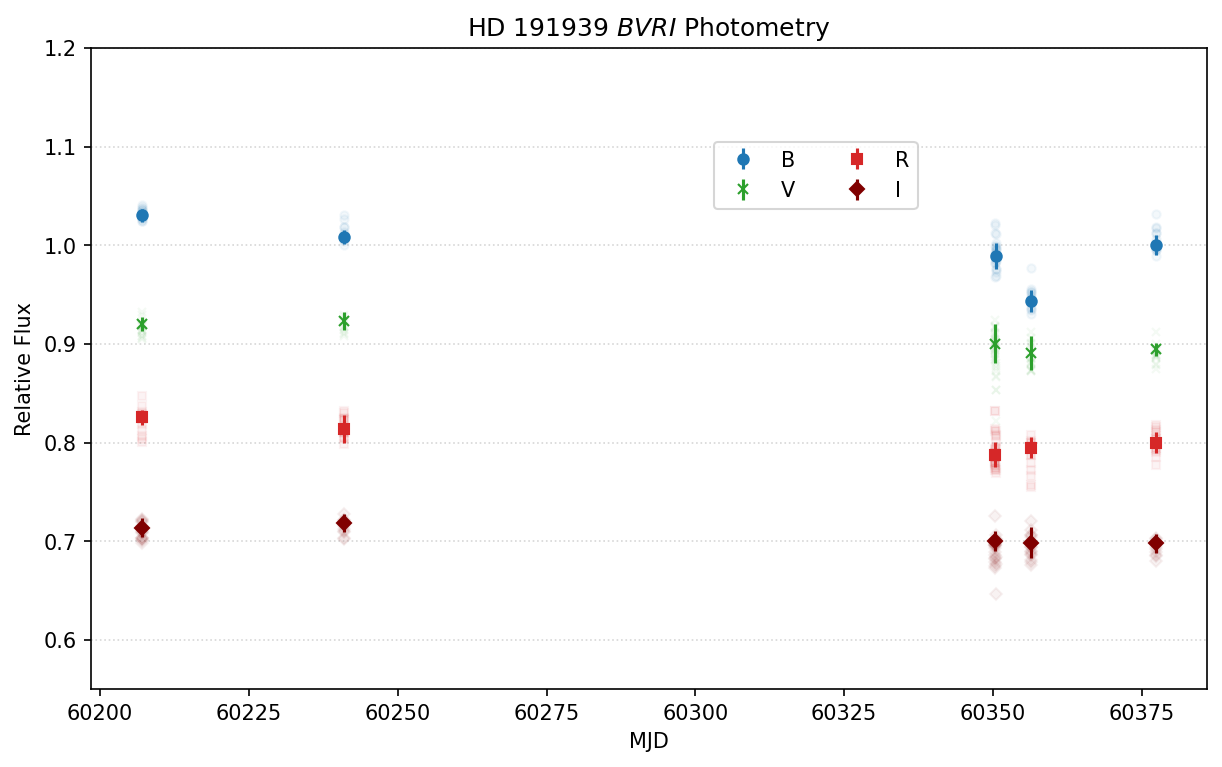

In [19]:
COLORS = {'B': 'C0', 'V': 'C2', 'R': 'C3', 'I': 'maroon'}
MARKERS = {'B': 'o', 'V': 'x', 'R': 's', 'I': 'D'}

fig, ax = plt.subplots(figsize=(6.4*1.5, 3.7*1.5), dpi=150)

for n, band in enumerate(BANDS):
    data = table[table['band'] == band]
    norm = np.median(data['phot'])
    after = data['jd'] > 2460024
    # after = data['jd'] > 0
    ax.plot(data[after]['jd'] - 2400000.5, data[after]['phot'] / norm - n * 0.1, MARKERS[band], alpha=0.05, markersize=4, c=COLORS[band])
    
    # plot binned
    binned = dat_binned[dat_binned['band'] == band]
    binned_norm = np.median(binned['phot'])
    after = binned['jd'] > 2460024
    # after = binned['jd'] > 0
    ax.errorbar(binned[after]['jd'] - 2400000.5,
                binned[after]['phot'] / binned_norm - n * 0.1,
                binned[after]['photerr'] / binned_norm, elinewidth=1.5,
                fmt=MARKERS[band], linewidth=0.3, markersize=5, c=COLORS[band], label=band)
ax.set_xlim(ax.get_xlim())
plot_hst('TOI-1201', hst, ax, 'C7')
ax.set_xlabel('MJD')
ax.set_ylabel('Relative Flux')
ax.set_title(r'HD 191939 $BVRI$ Photometry')
ax.legend(ncol=2, bbox_to_anchor=(0.75, 0.87))
# ax.set_xlim(60015,60110)
# ax.set_yticks(np.arange(0.3, 1.2, 0.1))
ax.set_ylim(0.55, 1.2)
ax.grid(axis='y', linestyle=':', alpha=0.5, which='both')
# plt.minorticks_on()

plt.show()

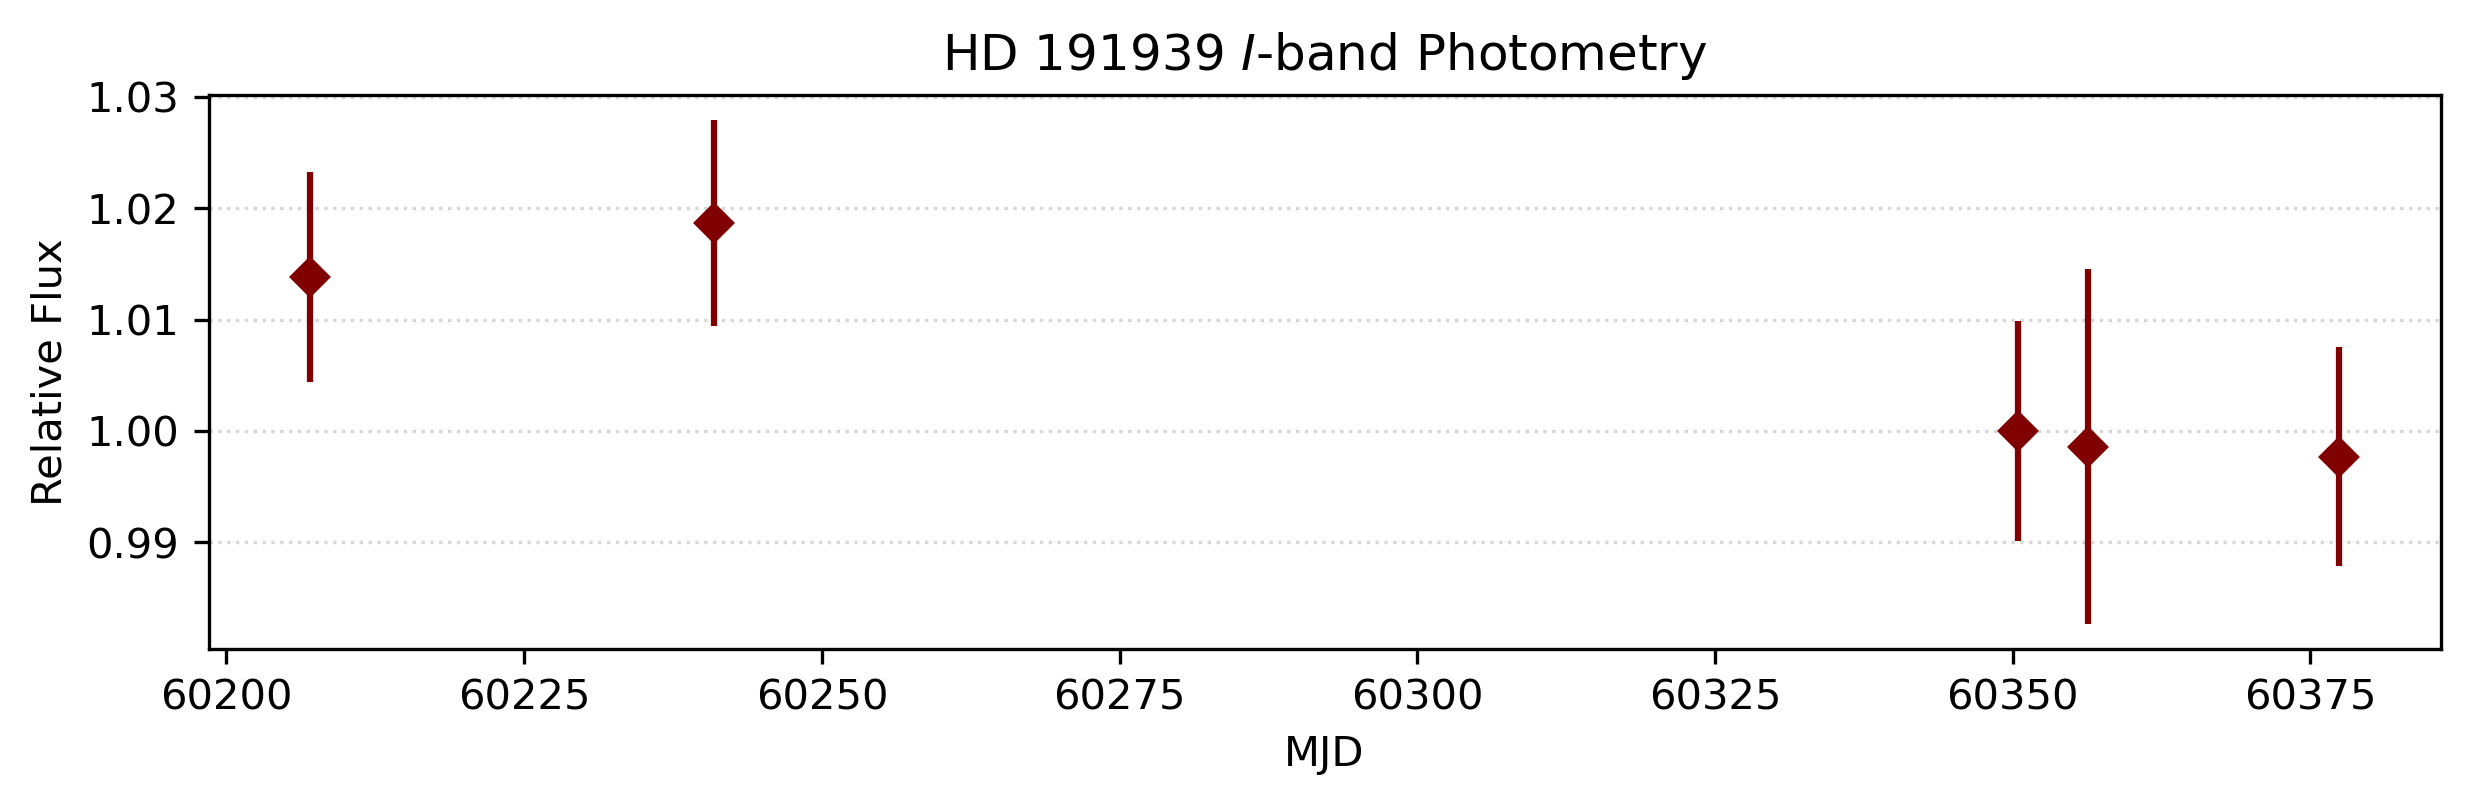

In [26]:
band = 'I'

fit, ax = plt.subplots(figsize=(6.4*1.5, 1.6*1.5), dpi=300)
binned = dat_binned[dat_binned['band'] == band]
binned_norm = np.median(binned['phot'])
after = binned['jd'] > 2460180
# after = binned['jd'] > 0
# ax.plot(binned[after]['jd'] - 2400000.5, binned[after]['phot'] / binned_norm, MARKERS[band], c=COLORS[band])
# plot_hst('TOI-1201', hst, ax, 'C7')
ax.errorbar(binned[after]['jd'] - 2400000.5,
        binned[after]['phot'] / binned_norm,
        binned[after]['photerr'] / binned_norm,
        fmt=MARKERS[band], c=COLORS[band])
# ax.set_xlim(60024.824164895945, 60098.40560119259)
ax.set_xlabel('MJD')
ax.set_ylabel('Relative Flux')
ax.set_title(f'HD 191939 ${band}$-band Photometry')
# ax.set_ylim(0.96, 1.03)
ax.grid(axis='y', linestyle=':', alpha=0.5)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(6.4*1.5, 2.2*1.5), dpi=150)

for n, band in enumerate(BANDS):
    data = table[table['band'] == band]
    range_ = np.logical_and(data['jd'] > 2460056.551, data['jd'] < 2460056.569)
    data = data[range_]
    norm = np.mean(data['phot'])
    ax.plot(data['jd'] - 2460056, data['phot'] / norm, MARKERS[band], markersize=5, c=COLORS[band], label=band)
    # ax.errorbar(data['jd'] - 2460056,
    #             data['phot'] / norm,
    #             data['photerr'] / norm,
    #             fmt=MARKERS[band], markersize=3, c=COLORS[band], label=band)
ax.set_xlabel('JD – 2460056')
ax.set_ylabel('Normalized Flux')
ax.set_title('HD 191939 $BVRI$ Photometry on April 21–22, 2023')
ax.legend(ncol=4)
# # ax.set_xlim(0.552, 0.569)
ax.set_ylim(0.955, 1.05)
# ax.set_yticks(np.arange(0.3, 1.2, 0.1))
# plt.minorticks_on()
ax.grid(axis='y', linestyle=':', alpha=0.5)
plt.show()

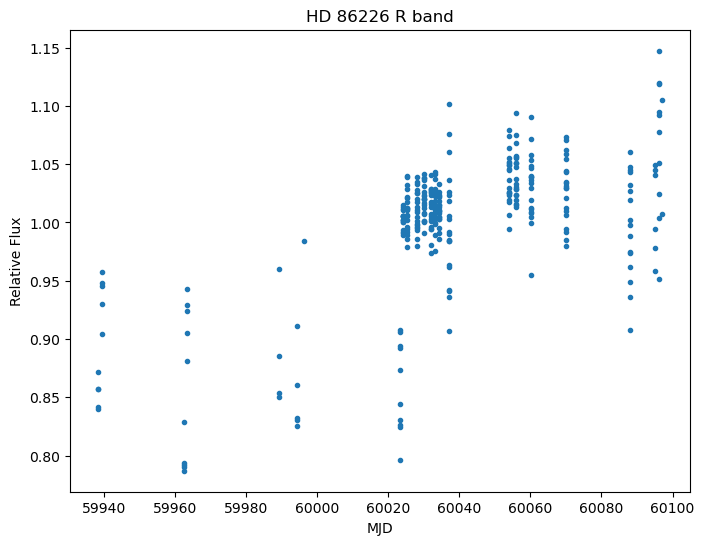

In [11]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(jds - 2400000.5, relflux / norm, '.')
ax.set_xlabel('MJD')
ax.set_ylabel('Relative Flux')
ax.set_title('HD 86226 R band')
# ax.set_xlim(60024)
plt.show()

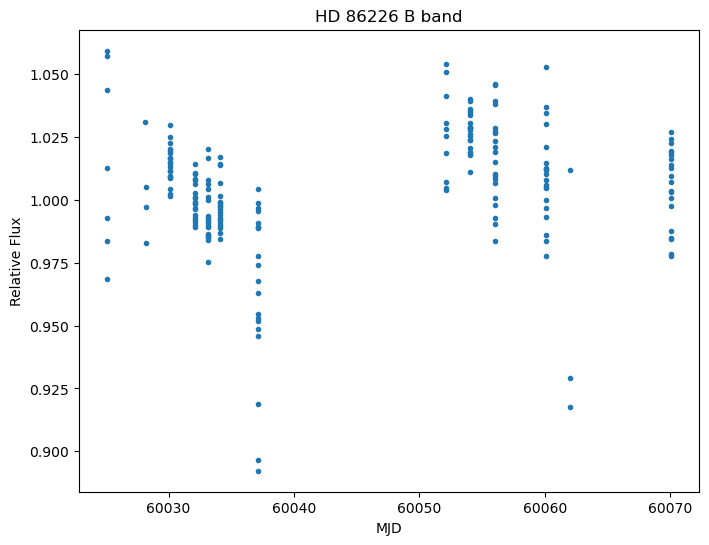

In [13]:
norm = np.mean(relflux)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(jds[jds > 2460024] - 2400000.5, relflux[jds > 2460024] / norm, '.')
ax.set_xlabel('MJD')
ax.set_ylabel('Relative Flux')
ax.set_title(f'HD 86226 {BAND} band')
# ax.set_xlim(60024)
plt.show()

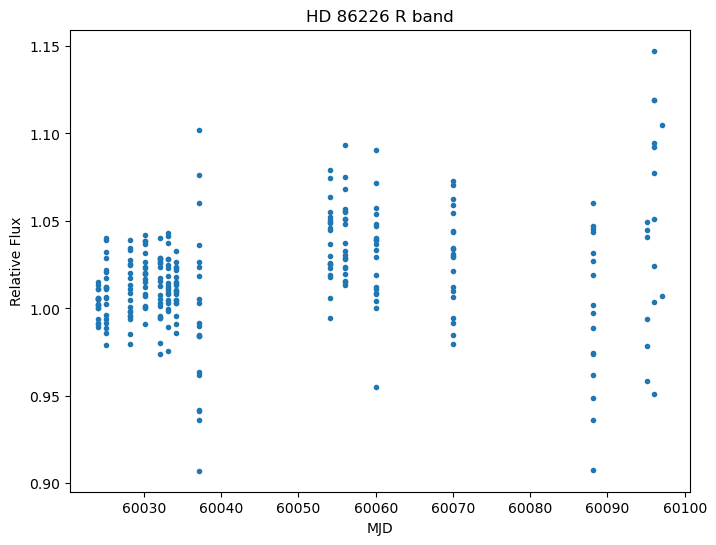

In [10]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(jds[jds > 2460024] - 2400000.5, relflux[jds > 2460024] / norm, '.')
ax.set_xlabel('MJD')
ax.set_ylabel('Relative Flux')
ax.set_title('HD 86226 R band')
# ax.set_xlim(60024)
plt.show()

### Lomb-Scargle and Periodigram

In [30]:
(binned[after]['jd'] - 2400000.5) * u.day, binned[after]['phot'] / binned_norm, binned[after]['photerr'] / binned_norm

(<Quantity [60145.33603947, 60193.32661649, 60194.36831597, 60195.33582853,
            60200.21182784, 60201.35391696, 60202.34721481, 60207.30755891,
            60208.33582465, 60215.36719236, 60219.24667245, 60225.28130573,
            60229.24647002, 60230.3024912 , 60231.27541076, 60236.25922049,
            60237.26969126, 60240.26001198, 60241.20154786, 60242.18153657,
            60243.28436609, 60244.21947211, 60245.22905301, 60250.23351927,
            60251.17436406, 60252.22685214, 60254.19587228, 60256.16147309,
            60260.17218096, 60261.16717639, 60262.14410185, 60263.22487541,
            60265.16547853, 60267.1223265 , 60271.18252222, 60274.11042975,
            60277.07731956, 60284.27404028, 60291.10937517, 60292.12402436,
            60293.10850017, 60294.10895451, 60297.1474838 , 60300.10943738,
            60301.11027078, 60309.12092789, 60311.0870614 , 60315.08414282,
            60349.05527257, 60352.09000613, 60357.01563877, 60358.02748964,
            

In [31]:
frequency

NameError: name 'frequency' is not defined

In [32]:
binned_after.pprint_all()

NameError: name 'binned_after' is not defined

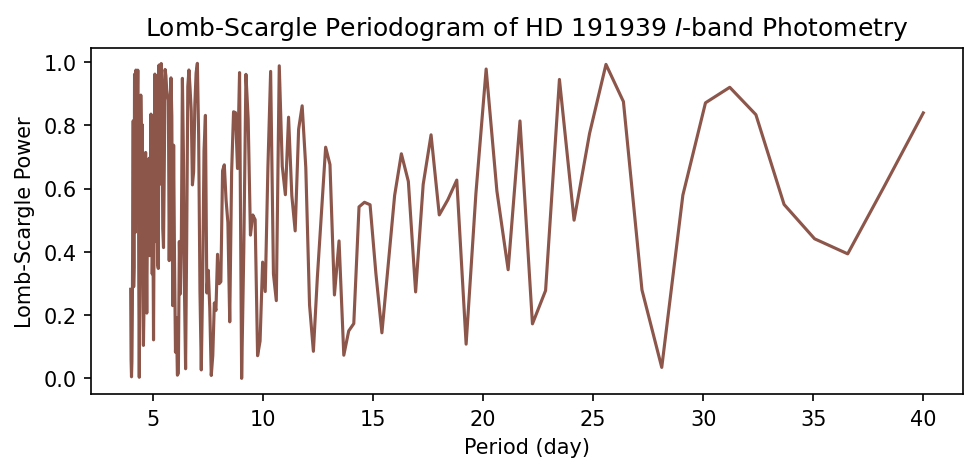

In [27]:
binned_after = binned#[after]
binned_after = binned_after[binned_after['photerr'] > 0.0]

frequency, power = LombScargle((binned_after['jd']) * u.day,
                               binned_after['phot'] * u.dimensionless_unscaled,
                               binned_after['photerr'] * u.dimensionless_unscaled).autopower(minimum_frequency=0.025 / u.day,
                                                                                              maximum_frequency=0.25 / u.day)
plt.figure(figsize=(7.5, 3), dpi=150)
plt.plot(1 / frequency, power, c='C5')
plt.xlabel('Period (day)')
plt.ylabel('Lomb-Scargle Power')
plt.title('Lomb-Scargle Periodogram of HD 191939 $I$-band Photometry')
plt.show()

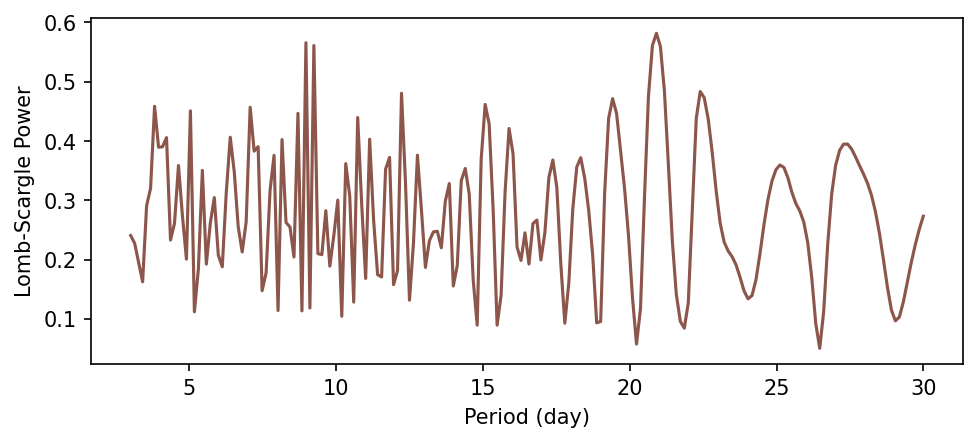

In [76]:
periods = np.linspace(3, 30, 200) * u.day

power = LombScargle((binned_after['jd']) * u.day,
                               binned_after['phot'] * u.dimensionless_unscaled,
                               binned_after['photerr'] * u.dimensionless_unscaled).power(1 / periods)
plt.figure(figsize=(7.5, 3), dpi=150)
plt.plot(periods, power, c='C5')
plt.xlabel('Period (day)')
plt.ylabel('Lomb-Scargle Power')
# plt.title('Lomb-Scargle Periodogram of HD 86226 $R$-band Photometry')
plt.show()

### HST Visit

In [10]:
import urllib.request
from xml.etree import ElementTree
from datetime import datetime

In [11]:
def hst_visits():
    """
    Process StSci HST GO 17192 XML status

    :return: time at which XML is fetched, dict of past visits, dict of future visits
    """
    archived = {}
    future = {}

    url = 'https://www.stsci.edu/cgi-bin/get-visit-status?id=17192&markupFormat=xml&observatory=HST'
    with urllib.request.urlopen(url) as response:
        xml_string = response.read().decode('utf-8')
    root = ElementTree.fromstring(xml_string)

    # iter around visits
    for v in root.iterfind('visit'):
        status = v.find('status').text
        target = v.find('target').text

        # keep only WFC3 observation
        config = v.find('configuration').text
        if not config.startswith('WFC3'):
            continue
        print(target, config)

        # find archived (done) visits
        starts = []
        for t in v.iterfind('startTime'):
            starts.append(datetime.strptime(t.text, '%b %d, %Y %H:%M:%S'))
        ends = []
        for t in v.iterfind('endTime'):
            ends.append(datetime.strptime(t.text, '%b %d, %Y %H:%M:%S'))
        for s, e in zip(starts, ends):
            if target not in archived:
                archived[target] = []
            archived[target].append((s, e))

        # find future plan windows
        for t in v.iterfind('planWindow'):
            start_end = t.text[:-22].split(' - ')
            start = datetime.strptime(start_end[0], '%b %d, %Y')
            end = datetime.strptime(start_end[1], '%b %d, %Y')
            if target not in future:
                future[target] = []
            future[target].append((start, end))

    url2 = 'https://www.stsci.edu/cgi-bin/get-visit-status?id=17414&markupFormat=xml&observatory=HST'
    with urllib.request.urlopen(url2) as response:
        xml_string2 = response.read().decode('utf-8')
    root2 = ElementTree.fromstring(xml_string2)

    # iter around visits
    for v in root2.iterfind('visit'):
        status = v.find('status').text
        target = v.find('target').text

        # keep only WFC3 observation
        config = v.find('configuration').text
        if not config.startswith('WFC3'):
            continue
        print(target, config)

        # find archived (done) visits
        starts = []
        for t in v.iterfind('startTime'):
            starts.append(datetime.strptime(t.text, '%b %d, %Y %H:%M:%S'))
        ends = []
        for t in v.iterfind('endTime'):
            ends.append(datetime.strptime(t.text, '%b %d, %Y %H:%M:%S'))
        for s, e in zip(starts, ends):
            if target not in archived:
                archived[target] = []
            archived[target].append((s, e))

        # find future plan windows
        for t in v.iterfind('planWindow'):
            start_end = t.text[:-22].split(' - ')
            start = datetime.strptime(start_end[0], '%b %d, %Y')
            end = datetime.strptime(start_end[1], '%b %d, %Y')
            if target not in future:
                future[target] = []
            future[target].append((start, end))

    # get time at which the information is fetched
    report_time = datetime.strptime(root2.find('reportTime').text, '%a %b %d %H:%M:%S %Z %Y')

    # print(report_time.strftime("%m/%d/%Y %H:%M"))

    return report_time, archived, future

In [12]:
def plot_hst(id, dict, ax, c):
    times = np.array(dict.get(id.replace(' ', '-')))
    if len(times.shape) > 1:
        for s, e in times:
            mid = s + (e - s) / 2
            ax.axvline(Time(mid).mjd, c=c, linewidth=0.3, alpha=1)
            # ax.axvline(Time(s).mjd, c=c, linewidth=0.1, alpha=0.8)
            # ax.axvline(Time(e).mjd, c=c, linewidth=0.1, alpha=0.8)

In [13]:
_, hst, _ = hst_visits()

HD-191939 WFC3/IR
HD-191939 WFC3/IR
HD-86226 WFC3/IR
HD-86226 WFC3/IR
HD-86226 WFC3/IR
HD-86226 WFC3/IR
HD-86226 WFC3/IR
HD-86226 WFC3/IR
HD-86226 WFC3/IR
HD-86226 WFC3/IR
HD-86226 WFC3/IR
HD-86226 WFC3/IR
HD-86226 WFC3/IR
HD-86226 WFC3/IR
TOI-1201 WFC3/IR
HD-191939 WFC3/IR
TOI-561 WFC3/IR
HD-86226 WFC3/IR
HD-86226 WFC3/IR
HD-86226 WFC3/IR
HD-86226 WFC3/IR
HD-86226 WFC3/IR
HD-86226 WFC3/IR
HD-86226 WFC3/IR
HD-86226 WFC3/IR
HD-86226 WFC3/IR
HD-86226 WFC3/IR
HD-86226 WFC3/IR
HD-86226 WFC3/IR
HD-86226 WFC3/IR
HD-86226 WFC3/IR
HD-86226 WFC3/IR
HD-86226 WFC3/IR
TOI-561 WFC3/IR
HD-86226 WFC3/IR
HD-86226 WFC3/IR
HD-86226 WFC3/IR
HD-86226 WFC3/IR
TOI-431 WFC3/IR
TOI-561 WFC3/IR
HD-86226 WFC3/IR
HD-86226 WFC3/IR
HD-86226 WFC3/IR
HD-86226 WFC3/IR
TOI-431 WFC3/IR
TOI-561 WFC3/IR
TOI-1201 WFC3/IR
TOI-1201 WFC3/IR
TOI-1201 WFC3/IR
TOI-1201 WFC3/IR
TOI-1201 WFC3/IR
TOI-561 WFC3/IR
TOI-431 WFC3/IR
TOI-561 WFC3/IR
TOI-1410 WFC3/IR
TOI-1410 WFC3/IR
TOI-1759 WFC3/IR
TOI-1759 WFC3/IR
TOI-1410 WFC3/IR
TOI

In [ ]:
hst

### Practice Round

In [147]:
PLOT = True

with fits.open('./2023-03-20T04-19-16.829_HD-86226-S001-R-R002-R.fts', output_verify='warn') as f:
    # get wcs
    wcs = WCS(f[0].header)
    t = f[0].header['JD']
    print(t)

    '''
    # convert sky coord to pix coord
    pix_aperture = aperture.to_pixel(wcs)
    pix_annuli = annuli.to_pixel(wcs)

    # data
    data = f[0].data

    # plot
    if PLOT:
        norm = simple_norm(data, 'sqrt', percent=99)
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.imshow(data, norm=norm, interpolation='nearest', cmap='gray')
        ap_patches = pix_aperture.plot(color='green', lw=1, label='Photometry aperture')
        ann_patches = pix_annuli.plot(color='black', lw=0.5, label='Background annulus')
        ax.legend(handles=[ap_patches[0], ann_patches[0]])
        plt.show()
    '''

    # centroiding
    centroids = ApertureStats(data, aperture, wcs=wcs).centroid

    # photometry
    sigclip = SigmaClip(sigma=3.0, maxiters=10)
    bkg_stats = ApertureStats(data,
                              CircularAnnulus(centroids, r_in=49.93205486857078, r_out=79.89128778971325),
                              sigma_clip=sigclip)
    aper_stats_bkgsub = ApertureStats(data,
                                      CircularAperture(centroids, r=39.94564389485662),
                                      local_bkg=bkg_stats.median,
                                      error=calc_total_error(np.array(data, dtype=np.float64), 0, 1.85))
    aper_stats_bkgsub.sum[0] / np.sum(aper_stats_bkgsub.sum[1:])

2460023.680055903


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


## RA/Dec List

In [4]:
radec = ascii.read('./hd19.radec')

# these are only for hd8.radec in station/vvophot
# include = np.full((17,), True)
# include[4] = include[5] = False

# radec = radec[include]

ra = radec['col1']
dec = radec['col2']

raangle = Angle([ira + ' hour' for ira in ra.data])
decangle = Angle([idec + ' degree' for idec in dec.data])

# raangle = Angle(ra, unit=u.hour)
# decangle = Angle(dec, unit=u.deg)

raangle

<Angle [20.13511028, 20.12528111, 20.12464444, 20.12964333, 20.13453278,
        20.13346528, 20.14280083, 20.12539861, 20.15171167, 20.1475525 ] hourangle>

In [8]:
decangle

<Angle [-14.537425  , -14.53185833, -14.58248611, -14.65309167,
        -14.38391667] deg>

## SkyCoord

In [5]:
apsize = np.array([14, 50, 90]) * 0.699 # tuple values in PIXEL (converted to arcsec)

positions = SkyCoord(raangle, decangle, frame=FK5)
aperture = SkyCircularAperture(positions, r=apsize[0] * u.arcsec)
annuli = SkyCircularAnnulus(positions, r_in=apsize[1] * u.arcsec, r_out=apsize[2] * u.arcsec)

In [6]:
aperture.positions

<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    [(302.02665417, 66.85019722), (301.87921667, 66.94086667),
     (301.86966667, 66.87885   ), (301.94465   , 66.876925  ),
     (302.01799167, 66.94576389), (302.00197917, 66.98110278),
     (302.1420125 , 66.95080556), (301.88097917, 66.74601667),
     (302.275675  , 66.8372    ), (302.2132875 , 66.87455278)]>

### SkyCoord to Pixel Coord

In [13]:
f = fits.open('./2023-03-20T04-19-16.829_HD-86226-S001-R-R002-R.fts')
wcs = WCS(f[0].header)

In [44]:
pix_aperture = aperture.to_pixel(wcs)
pix_annuli = annuli.to_pixel(wcs)

In [45]:
pix_aperture

<CircularAperture([[1003.55060947,  969.09946577],
                 [ 329.80515908, 1138.3633433 ],
                 [ 334.81924749,  967.49436927],
                 [ 540.07437907,  629.55233967],
                 [1484.63697039, 1502.510278  ],
                 [1468.4778774 , 1223.37583104],
                 [1715.4377437 , 1614.10633464],
                 [1484.5427604 , 1725.65446049],
                 [ 440.53710052, 1415.47915468],
                 [ 542.5993382 , 1560.87425738],
                 [ 468.47954448, 1716.02216979],
                 [ 766.62246608, 1434.76143773],
                 [1807.76002603,  557.52185972],
                 [1704.86056166,  636.12227068],
                 [1209.75534851,  189.9871152 ]], r=13.96100254125239)>

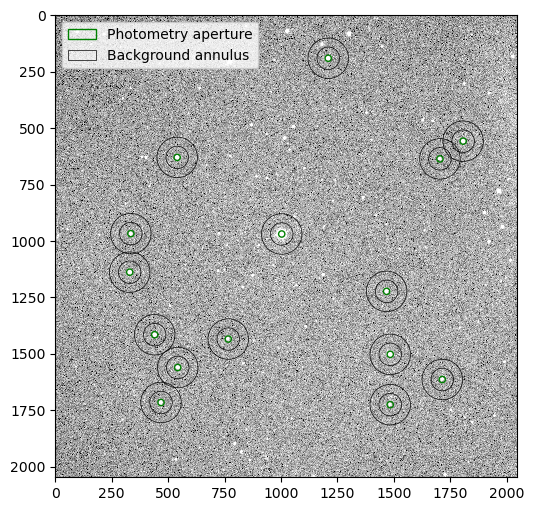

In [46]:
data = f[0].data
norm = simple_norm(data, 'sqrt', percent=99)
fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(data, norm=norm, interpolation='nearest', cmap='gray')

ap_patches = pix_aperture.plot(color='green', lw=1, label='Photometry aperture')
ann_patches = pix_annuli.plot(color='black', lw=0.5, label='Background annulus')
ax.legend(handles=[ap_patches[0], ann_patches[0]])
# handles = ()
# ax.legend(facecolor='#458989', labelcolor='white',
#            handles=handles)#, prop={'weight': 'bold', 'size': 11}) # loc=(0.17, 0.05),
plt.show()

## Centroiding

We compare the circular aperture (star) sums with and without centroiding. Without:

In [17]:
circstats = ApertureStats(data, aperture, wcs=wcs)
circstats.sum

array([9802382.24671628, 4850590.76293617, 4631736.8178573 ,
       4684008.20894412, 5106498.45199232, 4699456.30466155,
       4607221.3688994 , 4607267.06579821, 4666858.46298475,
       4680230.9499705 , 4711312.29431594, 4613709.34649995,
       4666341.04209528, 4607809.12615054, 4753078.34334444])

Raw aperture and centroid positions:

In [18]:
pix_aperture

<CircularAperture([[1003.55060947,  969.09946577],
                 [ 329.80515908, 1138.3633433 ],
                 [ 334.81924749,  967.49436927],
                 [ 540.07437907,  629.55233967],
                 [1484.63697039, 1502.510278  ],
                 [1468.4778774 , 1223.37583104],
                 [1715.4377437 , 1614.10633464],
                 [1484.5427604 , 1725.65446049],
                 [ 440.53710052, 1415.47915468],
                 [ 542.5993382 , 1560.87425738],
                 [ 468.47954448, 1716.02216979],
                 [ 766.62246608, 1434.76143773],
                 [1807.76002603,  557.52185972],
                 [1704.86056166,  636.12227068],
                 [1209.75534851,  189.9871152 ]], r=34.952438407999544)>

In [19]:
circstats.centroid

array([[1003.42364076,  969.17668184],
       [ 329.78180014, 1138.34557767],
       [ 334.79972542,  967.49947462],
       [ 540.06996035,  629.55364517],
       [1484.52996331, 1502.47807627],
       [1468.47690845, 1223.44126516],
       [1715.42312191, 1614.09806439],
       [1484.54245028, 1725.58428019],
       [ 440.52963336, 1415.48802917],
       [ 542.60624788, 1560.84283994],
       [ 468.48249872, 1716.01563703],
       [ 766.61220652, 1434.75188176],
       [1807.72101447,  557.52399367],
       [1704.8370838 ,  636.14235396],
       [1209.7139843 ,  189.99644187]])

 We can see that they are different. Now, we use the centroid apertures to get the sum

In [56]:
circ_cen = CircularAperture(circstats.centroid, r=(aper_stats_bkgsub.fwhm[0] * 1.4).value)
circ_cen

<CircularAperture([[1003.42364076,  969.17668184],
                 [ 329.78180014, 1138.34557767],
                 [ 334.79972542,  967.49947462],
                 [ 540.06996035,  629.55364517],
                 [1484.52996331, 1502.47807627],
                 [1468.47690845, 1223.44126516],
                 [1715.42312191, 1614.09806439],
                 [1484.54245028, 1725.58428019],
                 [ 440.52963336, 1415.48802917],
                 [ 542.60624788, 1560.84283994],
                 [ 468.48249872, 1716.01563703],
                 [ 766.61220652, 1434.75188176],
                 [1807.72101447,  557.52399367],
                 [1704.8370838 ,  636.14235396],
                 [1209.7139843 ,  189.99644187]], r=15.16227463534644)>

Now the sums are

In [21]:
circcenstats = ApertureStats(data, circ_cen)
circcenstats.sum

array([11212250.40150352,  6248221.0017333 ,  6027236.34816568,
        6079677.03086791,  6506376.22895203,  6098547.98239878,
        6005291.47581871,  6008333.81363989,  6064025.10065082,
        6077082.28886097,  6107804.1339271 ,  6012011.9961653 ,
        6063607.31576185,  6003302.55463376,  6148765.27905888])

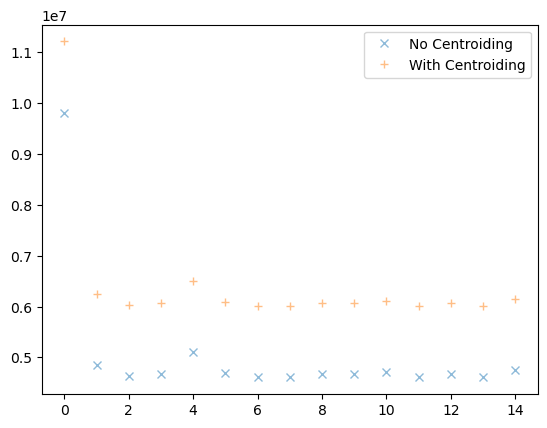

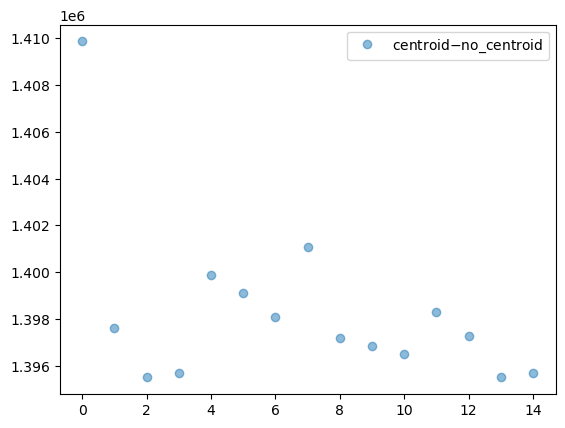

In [22]:
fig, ax = plt.subplots()
ax.plot(circstats.sum, 'x', alpha=0.5, label='No Centroiding')
ax.plot(circcenstats.sum, '+', alpha=0.5, label='With Centroiding')
ax.legend()
plt.show()

fig, ax = plt.subplots()
ax.plot(circcenstats.sum - circstats.sum, 'o', alpha=0.5, label='centroid$-$no_centroid')
ax.legend()
plt.show()

Okay, that looks good. Centroiding brings sum up, which is aligned with our expectation

## [Background](https://photutils.readthedocs.io/en/stable/aperture.html#background-subtraction)

In [23]:
sigclip = SigmaClip(sigma=3.0, maxiters=10)
aper_stats = ApertureStats(data, circ_cen, sigma_clip=None)
bkg_stats = ApertureStats(data,
                          CircularAnnulus(circstats.centroid, r_in=49.93205486857078, r_out=79.89128778971325),
                          sigma_clip=sigclip)

In [24]:
bkg_stats.median

array([1193., 1189., 1188., 1188., 1190., 1189., 1189., 1190., 1189.,
       1189., 1188., 1189., 1188., 1188., 1187.])

In [25]:
total_bkg = bkg_stats.median * aper_stats.sum_aper_area.value
total_bkg

array([5980385.34388239, 5960333.75848798, 5955320.86213938,
       5955320.86213938, 5965346.65483658, 5960333.75848798,
       5960333.75848798, 5965346.65483658, 5960333.75848798,
       5960333.75848798, 5955320.86213938, 5960333.75848798,
       5955320.86213938, 5955320.86213938, 5950307.96579077])

In [26]:
apersum_bkgsub = aper_stats.sum - total_bkg
apersum_bkgsub

array([5231865.05762113,  287887.24324532,   71915.4860263 ,
        124356.16872853,  541029.57411544,  138214.2239108 ,
         44957.71733073,   42987.15880331,  103691.34216284,
        116748.53037299,  152483.27178772,   51678.23767732,
        108286.45362247,   47981.69249438,  198457.31326811])

The above is the background-subtracted sum, but that's not useful in real life. Instead, we use:

In [27]:
aper_stats_bkgsub = ApertureStats(data, circ_cen, local_bkg=bkg_stats.median, error=calc_total_error(np.array(data, dtype=np.float64), 0, 1.85))
aper_stats_bkgsub.sum

array([5231865.05762113,  287887.24324532,   71915.4860263 ,
        124356.16872853,  541029.57411544,  138214.2239108 ,
         44957.71733073,   42987.15880331,  103691.34216284,
        116748.53037299,  152483.27178772,   51678.23767732,
        108286.45362247,   47981.69249438,  198457.31326811])

In [28]:
aper_stats_bkgsub.to_table()

id,xcentroid,ycentroid,sky_centroid,sum,sum_err,sum_aper_area,center_aper_area,min,max,mean,median,mode,std,mad_std,var,biweight_location,biweight_midvariance,fwhm,semimajor_sigma,semiminor_sigma,orientation,eccentricity
,,,,,,pix2,pix2,,,,,,,,,,,pix,pix,pix,deg,
int64,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,1003.2938321384618,969.2345023636534,None,5231865.057621132,2461.844002512061,5012.896348602169,5017.0,-65.0,64342.0,1042.8429340243174,28.0,-2001.6858680486348,5949.039851079945,40.030259899651256,35391075.1497373,23.454124583039658,1718.5337003378534,10.830196168104601,4.661623276378835,4.535838350465465,-88.92472583259655,0.23073374645619482
2,329.58995725828015,1138.2329788305226,None,287887.24324531946,1837.774947509535,5012.896348602169,5013.0,-74.0,5854.0,57.4524236983842,5.0,-99.9048473967684,358.4154173455626,22.23903327758403,128461.61139099383,3.736740094040381,514.4620279007967,10.559334611237322,4.917995637544347,4.003533432419312,-72.30605169478558,0.5807836592099588
3,333.96319154851267,967.7237698081735,None,71915.48602630076,1804.983543859353,5012.896348602169,5018.0,-65.0,1379.0,14.336388999601434,2.0,-22.672777999202868,90.14199879780558,20.75643105907843,8125.5799472635845,1.743988663093886,428.02679700664766,10.778514417918613,5.337465659166325,3.662407631158907,30.777387357166344,0.7274414303188095
4,539.8749065837371,629.5233400030536,None,124356.1687285328,1812.8187743338406,5012.896348602169,5006.0,-69.0,2405.0,24.858769476628048,3.0,-40.717538953256096,154.95431334085694,20.75643105907843,24010.839222936473,2.193487897968799,429.7993523593461,8.934522698563958,4.3349537752406135,3.1621526926320316,-1.9610590596429467,0.6840290520579703
5,1484.2433717265105,1502.145918092092,None,541029.5741154448,1875.3559992059777,5012.896348602169,5024.0,-67.0,10512.0,107.7312898089172,8.0,-191.4625796178344,660.6299269081596,23.721635496089633,436431.90032668033,6.170288718184608,567.2686442871402,11.377585796303077,4.8868239697969695,4.775769515270436,67.66138381810714,0.21197671157316364
6,1468.0444225645779,1223.0748291439825,None,138214.22391080376,1815.630034703728,5012.896348602169,5020.0,-64.0,2489.0,27.51553784860558,5.0,-40.03107569721116,160.29896234316794,20.75643105907843,25695.75732829638,3.7852036627459635,445.9576728777163,14.347605825045001,6.4905735221038645,5.667320080896831,78.91954406914535,0.48743069305594955
7,1714.8019035758762,1612.0880181462373,None,44957.71733072965,1801.6946190857498,5012.896348602169,5011.0,-67.0,873.0,8.973857513470366,2.0,-11.947715026940731,57.18001832089127,19.273828840572826,3269.554495177462,1.6042009221120312,400.5567218052986,13.794304417842874,6.458142101759171,5.188682489054789,-51.53429368666255,0.5953955917620063
8,1485.3531400065272,1720.8639330504918,None,42987.1588033117,1802.150939120504,5012.8963486021685,5017.0,-71.0,690.0,8.550528204106039,3.0,-8.101056408212077,48.467306680305505,20.75643105907843,2349.0798168427864,2.1750963531666687,431.7463700727303,22.569997483832935,12.833105342342659,4.363524615001772,-74.55310861965278,0.9404178626935223


In [29]:
bool(np.sum(aper_stats_bkgsub.max > 64340))

True

In [33]:
aper_stats_bkgsub.fwhm[0] * 1.4

<Quantity 15.16227464 pix>

In [138]:
f.close()

## Old Background Section (i.e. corresponds to the simple mean bkg sub)

We can use the `ApertureStats` class to compute the mean background level within the annulus aperture at each position:

In [13]:

aperstats = ApertureStats(data, annuli, wcs=wcs)
bkg_mean = aperstats.mean
print(bkg_mean)

[1193.2190596  1189.2129666  1188.60316212 1187.84231223 1190.59971667
 1189.53182784 1189.06243611 1190.63960988 1189.37783375 1189.30274436
 1188.78018868 1189.51300385 1187.98623131 1188.44456658 1190.80133543]


Now let’s use `aperture_photometry()` to perform the photometry in the circular aperture (in the next example, we’ll use `ApertureStats` to perform the photometry):

In [14]:

phot_table = aperture_photometry(data, aperture, wcs=wcs)
# for col in phot_table.colnames:
#     phot_table[col].info.format = '%.2f'  # for consistent table output
# print(phot_table)
phot_table

id,xcenter,ycenter,sky_center,aperture_sum
,pix,pix,"deg,deg",
int64,float64,float64,SkyCoord,float64
1,1003.5506094684569,969.0994657658848,"149.12329583333332,-24.09919722222222",11459619.24229525
2,329.8051590752444,1138.3633432953047,"148.98461666666665,-24.05205",6494157.482383674
3,334.8192474915641,967.494369274065,"149.0061333333333,-24.02518611111111",6272722.972474396
4,540.0743790723276,629.552339673471,"149.08291666666665,-23.993583333333333",6325408.797437248
5,1484.6369703909554,1502.5102780028674,"149.14327083333333,-24.23777777777778",6752556.184885119
6,1468.4778774025071,1223.3758310355654,"149.174175,-24.191208333333332",6344840.453775001
7,1715.4377437024602,1614.1063346431417,"149.17027083333332,-24.281074999999998",6250921.596936649
8,1484.5427604033118,1725.654460491879,"149.11624999999998,-24.273558333333334",6254787.607851893


The total background within the circular aperture is the mean local per-pixel background times the circular aperture area. If you are using the default “exact” aperture (see [aperture-mask methods](https://photutils.readthedocs.io/en/stable/aperture.html#photutils-aperture-overlap)) and there are no masked pixels, the exact analytical aperture area can be accessed via the aperture `area` attribute:

In [15]:

circ_mean = circstats.mean
circ_mean

array([2195.40574713, 1244.17854406, 1201.7779908 , 1211.84366628,
       1293.63354394, 1215.56467662, 1197.59938721, 1198.34507851,
       1208.88      , 1211.40057471, 1217.10579682, 1198.91147729,
       1208.73362696, 1197.14691216, 1225.02836879])

## Misc. Tryouts

In [16]:
circstats.__dict__.keys()

dict_keys(['_data', '_data_unit', 'aperture', '_error', '_mask', '_wcs', 'sigma_clip', 'sum_method', 'subpixels', '_pixel_aperture', 'isscalar', 'n_apertures', '_local_bkg', '_ids', 'default_columns', 'meta', '_aperture_masks_center', '_overlap_slices', '_data_cutouts', '_aperture_cutouts_center', '_mask_cutout_center', 'data_cutout', '_data_values_center', 'mean'])

In [17]:
aperstats.sigma_clip

In [18]:
aperture

<SkyCircularAperture(<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    [(149.12329583, -24.09919722), (148.98461667, -24.05205   ),
     (149.00613333, -24.02518611), (149.08291667, -23.99358333),
     (149.14327083, -24.23777778), (149.174175  , -24.19120833),
     (149.17027083, -24.281075  ), (149.11625   , -24.27355833),
     (148.97055   , -24.108725  ), (148.97087083, -24.14330556),
     (148.93907083, -24.15999444), (149.02545417, -24.1478    ),
     (149.3139875 , -24.121575  ), (149.286475  , -24.12289722),
     (149.2533125 , -23.99673611)]>, r=28.571428571428573 arcsec)>